In [1]:
# Base libraries
import os
from os.path import isfile, join
import numpy as np
import random
# NetworkX
import networkx as nx
import osmnx as ox
# Torch
import torch
from torch_geometric.nn import GAE
from torch_geometric.utils import from_networkx, train_test_split_edges
from torch_geometric.loader import GraphSAINTNodeSampler
# GNN models
from gnnuf_models import *
# OS environment setup
from local_directories import *

/opt/anaconda3/envs/gnn-urban-form/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Reset random seeds
random_seed = 2674
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Run on CUDA")
else:
    print("Run on CPU")

Run on CPU


In [6]:
# Load Leciester's graph
leicester = ox.io.load_graphml(bulk_storage_directory + "/osmnx/raw/leicester-1864.graphml")

In [ ]:
# A mile from node 24644030 encompass about the whole of the Leicester's city centre
leicester_town = nx.generators.ego_graph(leicester, 24644030, radius=1609.34, undirected=True, distance="length")
# Draw projected graph
leicester_town_projected = ox.project_graph(leicester_town)
ox.plot_graph(leicester_town_projected)
# ... or draw unprojected graph
# nx.draw(leicester_town, node_size=10, edge_color="#666666")

In [3]:
from gnnuf_models import VanillaGCNEncoder

model = GAE(VanillaGCNEncoder(2, 128, 64))
model.load_state_dict(torch.load(bulk_storage_directory + "/models/osmnx_model_v1.pt", map_location=torch.device('cpu')))
model.eval()

GAE(
  (encoder): VanillaGCNEncoder(
    (en_linear1): Linear(in_features=2, out_features=2, bias=True)
    (en_conv1): GCNConv(2, 128)
    (en_conv2): GCNConv(128, 128)
    (en_linear2): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): InnerProductDecoder()
)

In [4]:
def to_pyg_linegraph(ego_graph):
    seg_edges_length = nx.get_edge_attributes(ego_graph, "length")
    seg_edges_edges_grade_abs = nx.get_edge_attributes(ego_graph, "grade_abs")

    seg_linegraph = nx.line_graph(ego_graph)

    if len(seg_linegraph.nodes()) > 0:
        for seglg_node in seg_linegraph.nodes():
            seg_linegraph.nodes[seglg_node]["x"] = [
                seg_edges_length[(seglg_node[0], seglg_node[1], 0)],
                seg_edges_edges_grade_abs[(seglg_node[0], seglg_node[1], 0)]
            ]
            # print(seg_edges_length[(seglg_node[0], seglg_node[1], 0)])
            # print(seg_edges_edges_grade_abs[(seglg_node[0], seglg_node[1], 0)])
            # print("\n")
        if 'seglg_node' in locals():
            del seglg_node

        # print([sampled_ego_graph.nodes[n] for n in sampled_ego_graph.nodes()])

        pyg_graph = from_networkx(seg_linegraph)

        if pyg_graph.num_nodes > 0:
            return pyg_graph
        else:
            return None
    else:
        return None

In [ ]:
leicester_town_pyglg = to_pyg_linegraph(leicester_town)
leicester_town_pyglg_emb = model.encode(leicester_town_pyglg.x, leicester_town_pyglg.edge_index)
leicester_town_pyglg_emb

In [ ]:
# Check the nodes to find Clarendon Park, 52.616979, -1.116798
for node in leicester.nodes:
    if (
        -1.117 < leicester.nodes[node]["x"] < -1.116 and
        52.6155 < leicester.nodes[node]["y"] < 52.6170
        ):
        print(f"{node=}")
        print(f"{leicester.nodes[node]}\n")
del node

In [ ]:
leicester_clpk = nx.generators.ego_graph(leicester, 298259580, radius=1609.34, undirected=True, distance="length")
leicester_clpk_projected = ox.project_graph(leicester_clpk)
ox.plot_graph(leicester_clpk_projected)

In [ ]:
leicester_clpk_pyglg = to_pyg_linegraph(leicester_clpk)
leicester_clpk_pyglg_emb = model.encode(leicester_clpk_pyglg.x,leicester_clpk_pyglg.edge_index)
leicester_clpk_pyglg_emb

In [ ]:
# Check the nodes to find Belgrave Rd, 52.651087, -1.121639
for node in leicester.nodes:
    if (
        -1.122 < leicester.nodes[node]["x"] < -1.121 and
        52.6505 < leicester.nodes[node]["y"] < 52.6515
        ):
        print(f"{node=}")
        print(f"{leicester.nodes[node]}\n")
del node

In [ ]:
leicester_blgv = nx.generators.ego_graph(leicester, 5540547233, radius=1609.34, undirected=True, distance="length")
leicester_blgv_projected = ox.project_graph(leicester_blgv)
ox.plot_graph(leicester_blgv_projected)

In [ ]:
leicester_blgv_pyglg = to_pyg_linegraph(leicester_blgv)
leicester_blgv_pyglg_emb = model.encode(leicester_blgv_pyglg.x,leicester_blgv_pyglg.edge_index)
leicester_blgv_pyglg_emb

In [ ]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
from torch_geometric.nn import global_mean_pool

In [ ]:
cos(global_mean_pool(leicester_town_pyglg_emb, None), global_mean_pool(leicester_clpk_pyglg_emb, None))

In [ ]:
cos(global_mean_pool(leicester_town_pyglg_emb, None), global_mean_pool(leicester_blgv_pyglg_emb, None))

In [ ]:
cos(global_mean_pool(leicester_clpk_pyglg_emb, None), global_mean_pool(leicester_blgv_pyglg_emb, None))

In [8]:
leicester_embs = {}

counter = 0
for node in leicester.nodes:
    counter += 1
    if counter <= 100:
        node_ego_graph = nx.generators.ego_graph(leicester, node, radius=1609.34, undirected=True, distance="length")
        node_pyglg = to_pyg_linegraph(node_ego_graph)
        #print(node_pyglg)
        if node_pyglg is not None:
            node_pyglg_emb = model.encode(node_pyglg.x,node_pyglg.edge_index)
            node_pyglg_emb_gmp = global_mean_pool(node_pyglg_emb, None)
            #print(node_pyglg_emb_gmp)
            print(node)
            leicester_embs[node] = np.squeeze(node_pyglg_emb_gmp.cpu().detach().numpy())
        else:
            print("None")

194739
326312
326313
326320
326321
None
337952
337976
337979
337983
337985
337986
337992
506077
506082
506085
506087
506090
506091
604992
605000
605003
605005
605006
605007
605009
605012
605025
605059
605060
605061
605064
605066
605074
605078
605093
605095
605098
605110
605112
605113
9832562
9832563
9832572
9832573
9832589
9832596
9832597
9832598
9832602
9832603
9832607
9832609
9832614
9832615
9832616
9832619
9832624
9832629
9832634
9832635
9832637
9832639
9832643
9832645
9832649
9832655
9883491
9883492
9883496
9883498
9899501
9899517
9899519
9899524
9899525
9899527
9899529
9920433
9920435
9920438
9920440
9920441
9920444
9920445
9920446
9920447
9920452
9920457
9920473
9920478
9920479
9920486
9920510
9922686
9922687
9922689
9922690
9922696
9922698


In [13]:
leicester_embs

{194739: array([ 7.79951438e-02, -8.26434717e-02,  1.00057699e-01,  7.12729022e-02,
        -2.16614027e-02,  1.91791624e-01,  4.05328497e-02, -5.72328418e-02,
        -6.65153656e-03,  1.29912362e-01,  1.60328493e-01, -5.72909713e-02,
         1.19768670e-02, -6.86077550e-02, -3.41468640e-02,  2.52715230e-01,
        -2.59902120e-01,  1.98098719e-01,  1.91125888e-02, -1.22062027e-01,
        -6.59290422e-03,  2.54171565e-02,  4.78439480e-02,  8.75148550e-02,
         5.28640710e-02,  1.19404763e-01,  1.29981995e-01, -5.43874800e-01,
        -9.31988955e-02, -1.58620194e-01,  1.18788421e-01,  4.19317372e-02,
        -5.41347675e-02,  5.25843294e-04,  3.88702974e-02,  8.24680626e-02,
         2.49285921e-01,  1.27448842e-01, -1.08775459e-02, -2.16559261e-01,
        -5.20733669e-02,  1.21643521e-01,  6.97155967e-02,  1.23320147e-01,
         1.88744999e-02,  9.16152745e-02,  4.29630233e-03,  4.55843247e-02,
        -4.44485918e-02,  4.07227911e-02,  1.83089927e-01,  1.21062271e-01,
    

In [14]:
import pandas as pd
leicester_embs_df = pd.DataFrame.from_dict(leicester_embs, orient="index")

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
194739,0.077995,-0.082643,0.100058,0.071273,-0.021661,0.191792,0.040533,-0.057233,-0.006652,0.129912,...,-0.114571,-0.118279,-0.131184,-0.078964,0.105632,-0.008354,0.046668,0.061940,-0.058889,0.088338
326312,0.053359,-0.311157,0.068631,0.309644,-0.096197,0.402311,0.119346,-0.041766,0.100559,0.182063,...,-0.193514,-0.210840,-0.303490,-0.350463,0.343824,0.142358,0.075860,0.202944,-0.256043,0.261203
326313,0.076828,-0.039414,0.108099,0.059532,-0.014798,0.130385,0.038161,-0.008653,-0.016626,0.078607,...,-0.058819,-0.114502,-0.101803,-0.034421,0.052727,-0.029245,0.040801,0.028856,-0.056148,0.038617
326320,0.023216,-0.063894,0.047519,0.020325,-0.030330,0.243281,-0.019556,-0.105873,0.009584,0.194851,...,-0.146094,-0.135852,-0.126440,-0.071007,0.130111,-0.003657,0.013303,0.111474,0.027566,0.128710
326321,0.078595,-0.058428,0.073987,0.062794,0.000163,0.106640,0.031173,-0.020706,-0.002889,0.071640,...,-0.050483,-0.093033,-0.078053,-0.050029,0.042966,-0.003573,0.047709,0.017661,-0.060294,0.040283


In [21]:
leicester_embs_df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
194739,0.077995,-0.082643,0.100058,0.071273,-0.021661,0.191792,0.040533,-0.057233,-0.006652,0.129912,...,-0.114571,-0.118279,-0.131184,-0.078964,0.105632,-0.008354,0.046668,0.061940,-0.058889,0.088338
326312,0.053359,-0.311157,0.068631,0.309644,-0.096197,0.402311,0.119346,-0.041766,0.100559,0.182063,...,-0.193514,-0.210840,-0.303490,-0.350463,0.343824,0.142358,0.075860,0.202944,-0.256043,0.261203
326313,0.076828,-0.039414,0.108099,0.059532,-0.014798,0.130385,0.038161,-0.008653,-0.016626,0.078607,...,-0.058819,-0.114502,-0.101803,-0.034421,0.052727,-0.029245,0.040801,0.028856,-0.056148,0.038617
326320,0.023216,-0.063894,0.047519,0.020325,-0.030330,0.243281,-0.019556,-0.105873,0.009584,0.194851,...,-0.146094,-0.135852,-0.126440,-0.071007,0.130111,-0.003657,0.013303,0.111474,0.027566,0.128710
326321,0.078595,-0.058428,0.073987,0.062794,0.000163,0.106640,0.031173,-0.020706,-0.002889,0.071640,...,-0.050483,-0.093033,-0.078053,-0.050029,0.042966,-0.003573,0.047709,0.017661,-0.060294,0.040283


In [16]:
from umap import UMAP
leicester_embs_umap = UMAP(n_neighbors=3, n_components=2, min_dist=0.0, metric='cosine').fit_transform(leicester_embs_df)

In [19]:
leicester_embs_umap[:,0]

array([ 13.60665  ,  13.683171 ,  13.944563 ,  13.62203  ,  13.935693 ,
        13.672475 ,  13.991821 ,  14.21918  ,  14.067483 ,  14.06462  ,
        14.049938 ,  14.2052355,  21.895828 ,  21.400707 ,  21.854033 ,
        21.285742 ,  21.485477 ,  21.841595 ,  21.908005 ,  21.01393  ,
        21.261805 ,  21.050432 ,  20.925728 ,  20.930456 ,  20.870485 ,
        21.72671  ,   4.7879763,  14.522457 ,  14.44404  ,  14.497681 ,
        14.118642 ,  13.942479 ,  14.053056 ,  14.051879 ,  15.842695 ,
        15.901726 ,  15.986786 ,  16.288012 ,  16.409197 ,  16.426146 ,
         4.7879944,   4.787994 ,  -5.187542 ,  -5.2193594,  -4.0760636,
         2.8367193,   2.8541687,   2.8065252,  -4.446288 ,  -4.3873563,
        -5.543116 ,  -4.351619 ,  -5.4423275,  -5.380755 ,  -5.703373 ,
        -2.2979398,  -9.5873165,  -9.5819025,  -7.2981243,  -7.3680196,
        -7.362818 ,  -7.367721 ,  -7.255714 , -10.04112  , -10.129953 ,
       -10.169849 ,  -3.4558997,  -3.4901223,   2.0528278,   2.9

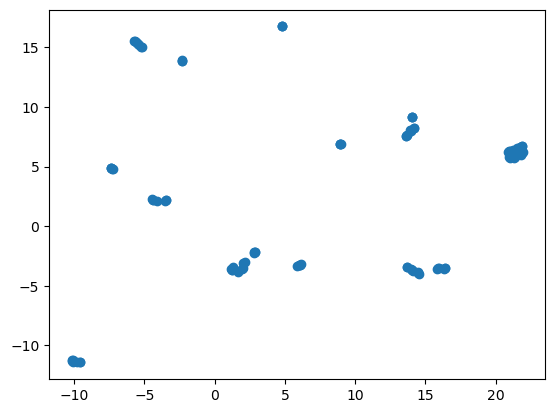

In [20]:
import matplotlib.pyplot as plt
plt.scatter(leicester_embs_umap[:,0], leicester_embs_umap[:,1])
plt.show()

In [22]:
leicester_embs_df["UMAP0"] = leicester_embs_umap[:,0]
leicester_embs_df["UMAP1"] = leicester_embs_umap[:,1]

In [30]:
leicester_embs_df[leicester_embs_df.index == 9832655][["UMAP0", "UMAP1"]]

,UMAP0,UMAP1
9832655,-10.169849,-11.256348


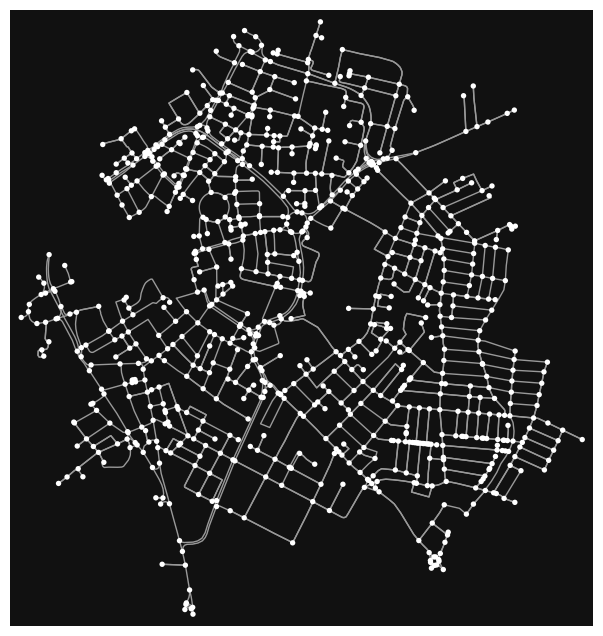

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [26]:
leicester_test01 = nx.generators.ego_graph(leicester, 9832655, radius=1609.34, undirected=True, distance="length")
leicester_test01_projected = ox.project_graph(leicester_test01)
ox.plot_graph(leicester_test01_projected)

In [41]:
leicester_embs_df[leicester_embs_df.index == 604992][["UMAP0", "UMAP1"]]

,UMAP0,UMAP1
604992,21.908005,6.200212


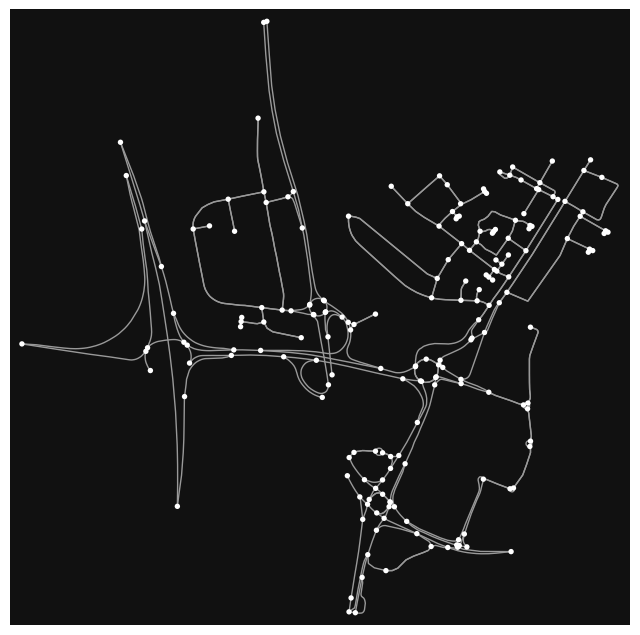

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [31]:
leicester_test02 = nx.generators.ego_graph(leicester, 604992, radius=1609.34, undirected=True, distance="length")
leicester_test02_projected = ox.project_graph(leicester_test02)
ox.plot_graph(leicester_test02_projected)

In [33]:
leicester_embs_df[leicester_embs_df.index == 9832562][["UMAP0", "UMAP1"]]

,UMAP0,UMAP1
9832562,4.787994,16.753477


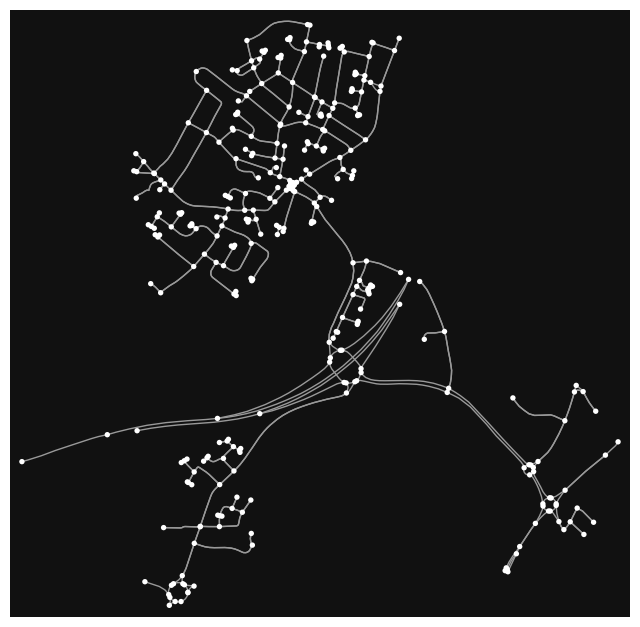

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [34]:
leicester_test03 = nx.generators.ego_graph(leicester, 9832562, radius=1609.34, undirected=True, distance="length")
leicester_test03_projected = ox.project_graph(leicester_test03)
ox.plot_graph(leicester_test03_projected)

In [39]:
leicester_embs_df[((0 < leicester_embs_df["UMAP1"]) & (leicester_embs_df["UMAP1"] < 4))]

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,UMAP0,UMAP1
9832589,0.034333,-0.002238,0.015287,0.013238,0.018478,-0.013745,0.017118,-0.000250,-0.002613,-0.003305,...,0.006906,0.000609,-0.016729,0.000147,0.014756,-0.026049,-0.023635,-0.005967,-4.076064,2.122533
9832602,0.047665,-0.017229,0.028212,0.045264,0.033586,-0.005376,0.036473,0.004499,0.011211,-0.000365,...,-0.006910,-0.016076,-0.002401,0.012744,0.014382,-0.017602,-0.052302,0.000132,-4.446288,2.263031
9832603,0.057227,-0.020484,0.046511,0.054879,0.034243,0.000380,0.046122,0.004312,0.008327,0.000708,...,-0.019148,-0.019784,0.003664,0.008204,0.015400,-0.012481,-0.061482,-0.000501,-4.387356,2.215362
9832609,0.047654,-0.017554,0.028011,0.043017,0.032539,-0.007920,0.034246,0.004299,0.010078,-0.001041,...,-0.005568,-0.015148,-0.005591,0.011820,0.015524,-0.018367,-0.050363,-0.002232,-4.351619,2.188833
9883491,0.027480,-0.010158,-0.000351,0.033169,0.027674,-0.027921,0.016835,0.022263,0.020141,-0.020303,...,0.012568,-0.008359,-0.021687,0.021434,0.009499,-0.022266,-0.037984,-0.005970,-3.455900,2.215976
9883492,0.014630,-0.003908,-0.006659,0.029701,0.016955,-0.030983,0.013666,0.038452,0.025091,-0.033058,...,0.015014,-0.005217,-0.022761,0.022707,0.003016,-0.020631,-0.035174,-0.004007,-3.490122,2.185392
9920452,0.028286,-0.008625,0.005288,0.033705,0.025139,-0.024171,0.018684,0.023578,0.018452,-0.020333,...,0.007837,-0.007810,-0.018450,0.018258,0.009118,-0.019566,-0.038334,-0.005027,-3.543169,2.153157


In [42]:
leicester_embs_df[leicester_embs_df.index == 9920452][["UMAP0", "UMAP1"]]

,UMAP0,UMAP1
9920452,-3.543169,2.153157


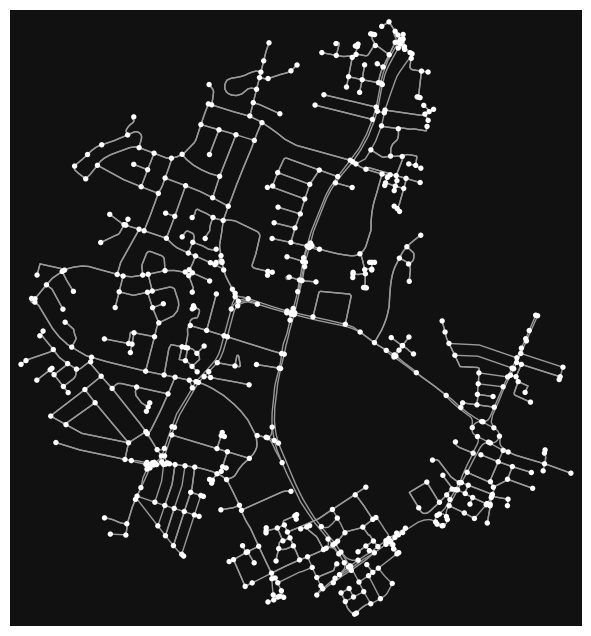

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [40]:
leicester_test04 = nx.generators.ego_graph(leicester, 9920452, radius=1609.34, undirected=True, distance="length")
leicester_test04_projected = ox.project_graph(leicester_test04)
ox.plot_graph(leicester_test04_projected)

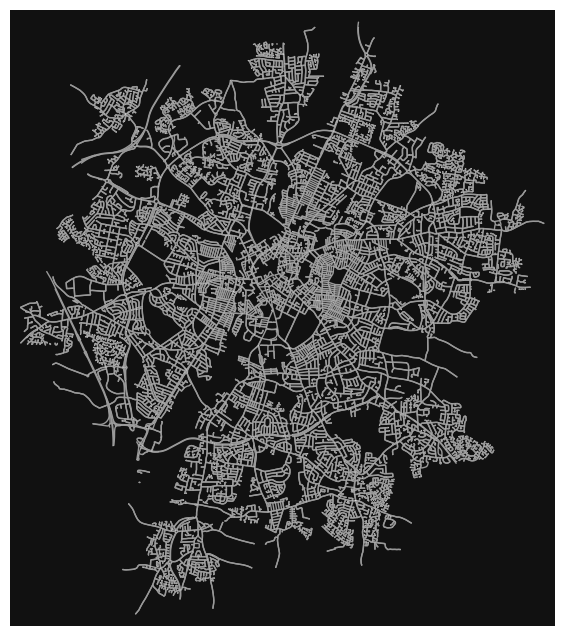

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [44]:
leicester_projected = ox.project_graph(leicester)
ox.plot_graph(leicester_projected, node_size=0.1)